## Importing important libraries

In [44]:
import warnings
warnings.filterwarnings('ignore')

In [45]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pathlib import Path 
from PIL import Image
import plotly.graph_objects as go

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

import keras
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3 as PTModel
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import model_from_json, Model

# Loading Data

In [46]:
base = Path("/kaggle/input/img-resized")
df = pd.read_csv(base / 'trainLabels.csv')
df.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [47]:
df['Id'] = df['image'].apply(lambda x: x.split('_')[0])
df['path'] = df['image'].apply(lambda x: base / "img_resized/img_resized" / f'{x}.jpeg')
df['exists'] = df['path'].apply(lambda x: x.exists())

print(f"{df['exists'].sum()} images found of {df.shape[0]} total")

df['eye'] = df['image'].str.split('_').str[-1].apply(lambda x: 1 if x == 'left' else 0)

df['level_categorical'] = df['level'].apply(lambda x: to_categorical(x, 1+df['level'].max()))

df.dropna(inplace = True)
df = df[df['exists']]

df.head()

35126 images found of 35126 total


,image,level,Id,path,exists,eye,level_categorical
0,10_left,0,10,/kaggle/input/img-resized/img_resized/img_resi...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
1,10_right,0,10,/kaggle/input/img-resized/img_resized/img_resi...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
2,13_left,0,13,/kaggle/input/img-resized/img_resized/img_resi...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
3,13_right,0,13,/kaggle/input/img-resized/img_resized/img_resi...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
4,15_left,1,15,/kaggle/input/img-resized/img_resized/img_resi...,True,1,"[0.0, 1.0, 0.0, 0.0, 0.0]"


In [48]:
unique_level = list(df['level'].unique())
unique_level

[0, 1, 2, 4, 3]

## Display Images

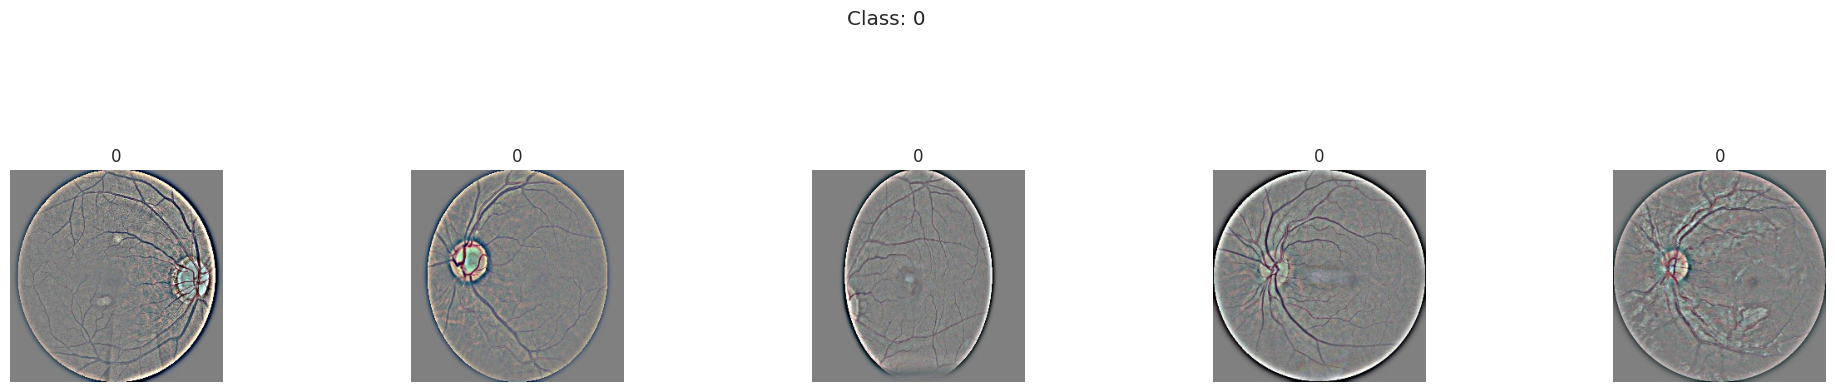

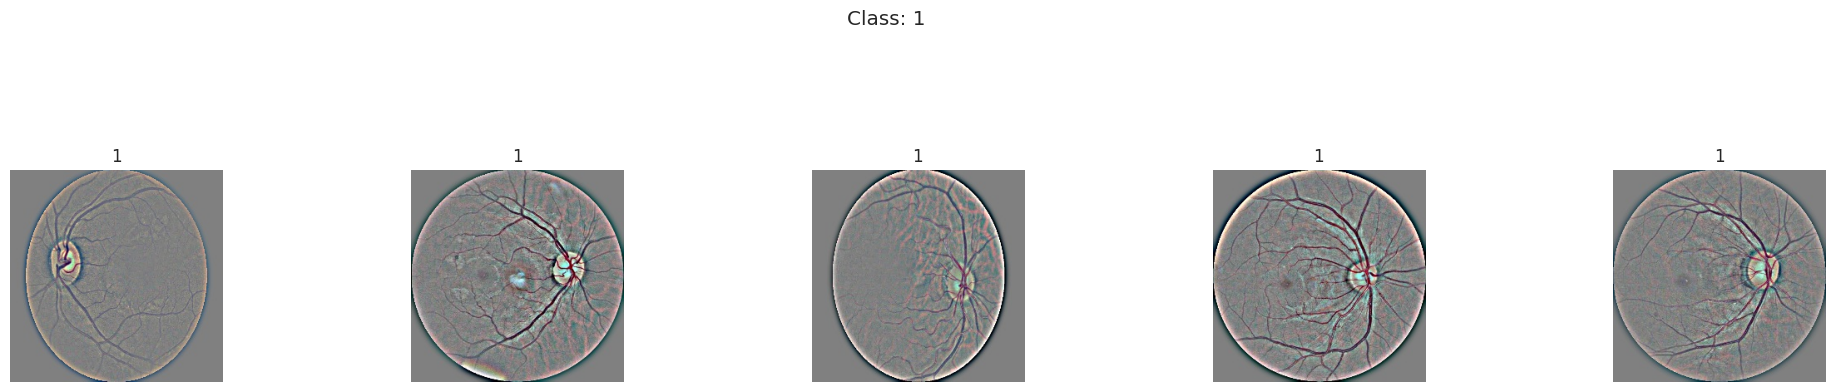

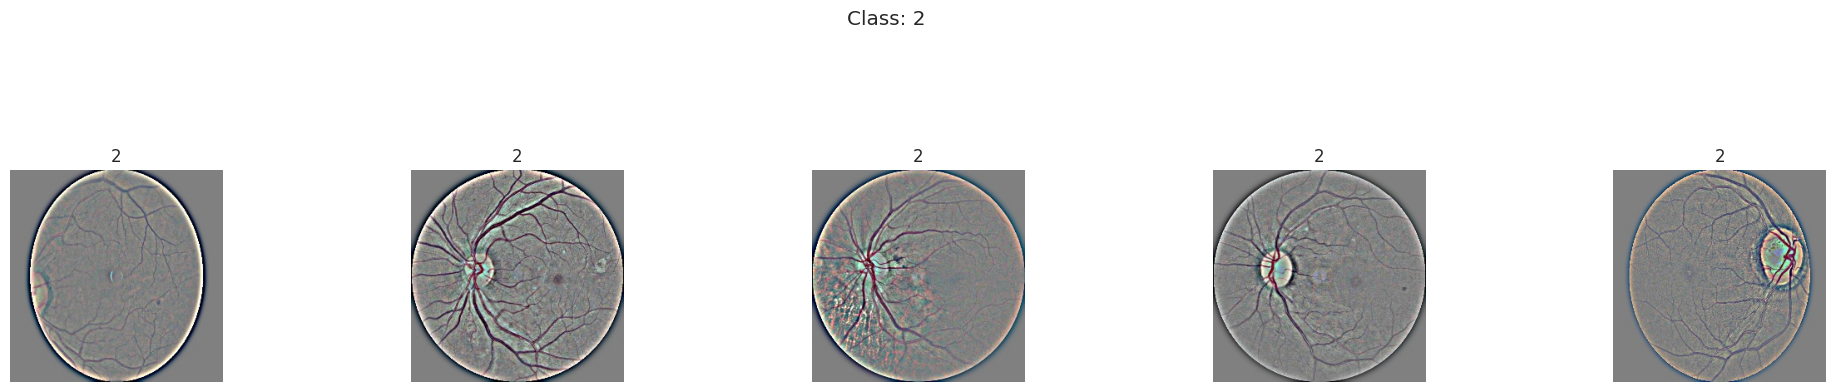

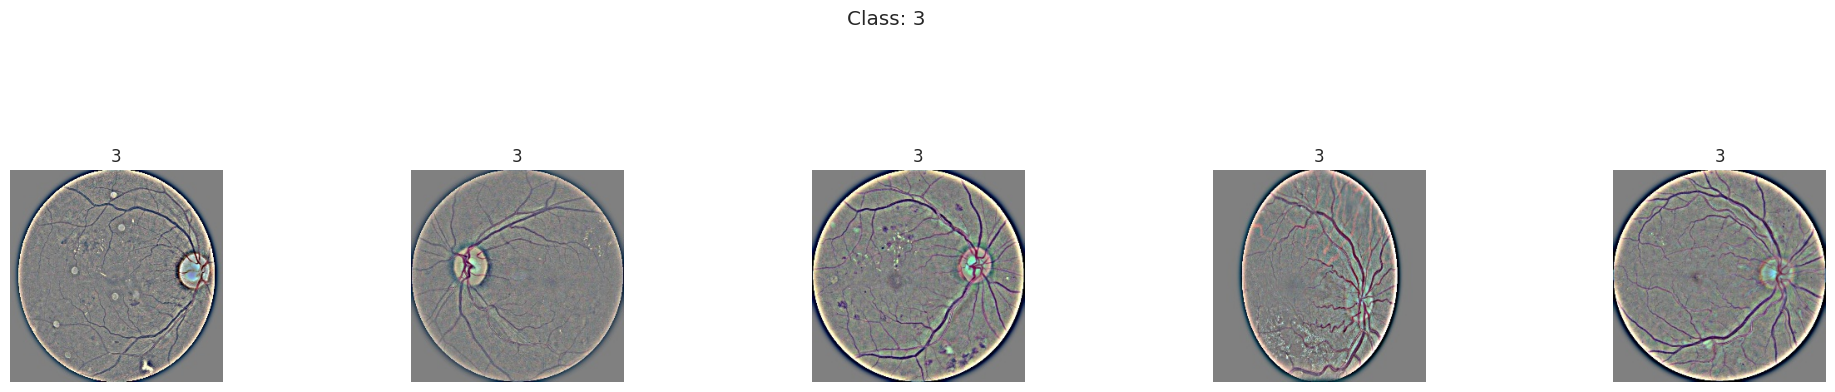

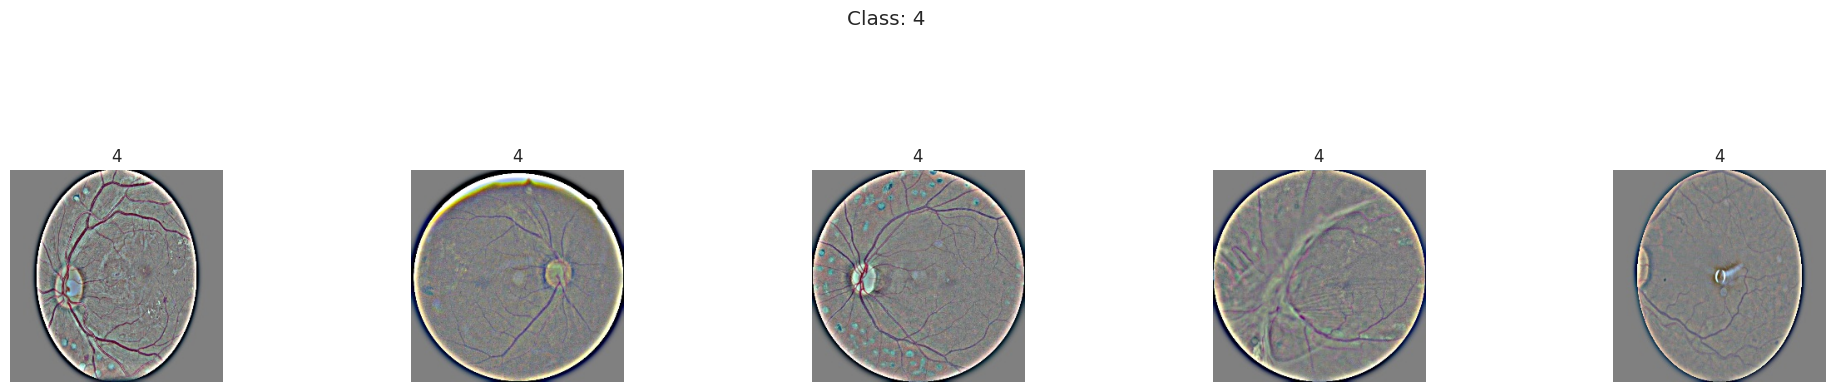

In [49]:
# Display function
def display_images(images, labels, title):
    plt.figure(figsize=(25, 16))
    for idx, (img_path, label) in enumerate(zip(images, labels)):
        plt.subplot(5, 5, idx+1)
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Group by labels
grouped = df.groupby('level')

# Iterate over each class and display 10 images
for label, group in grouped:
    # Select 5 images
    selected = group.sample(min(5, len(group)))
    image_paths = selected['path'].tolist()
    labels = selected['level'].tolist()
    
    # Display images
    display_images(image_paths, labels, f"Class: {label}")

## EDA

### Distribution of Severity Levels

The severity levels are typically categorized from 0 to 4:<br>
<li>0 - No DR</li>
<li>1 - Mild</li>
<li>2 - Moderate</li>
<li>3 - Severe</li>
<li>4 - Proliferative DR</li>

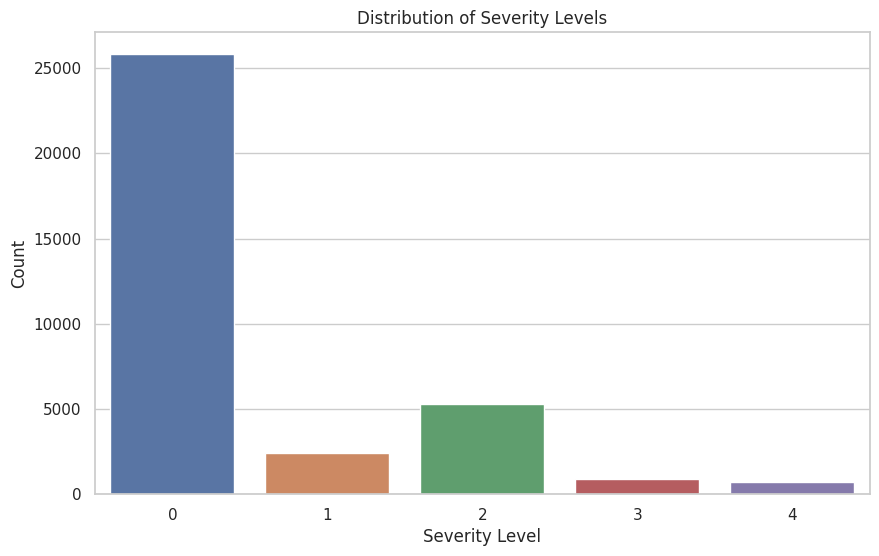

In [50]:
# Distribution of Diabetic Retinopathy Severity Levels
plt.figure(figsize=(10, 6))
sns.countplot(x='level', data=df)
plt.title('Distribution of Severity Levels')
plt.xlabel('Severity Level')
plt.ylabel('Count')
plt.show()

In [51]:
source = df['level'].value_counts()
fig = go.Figure(data=[go.Pie(labels=source.index,values=source.values)])
fig.update_layout(title='Distribution of Severity Levels')
fig.show()

### Distribution of Eye

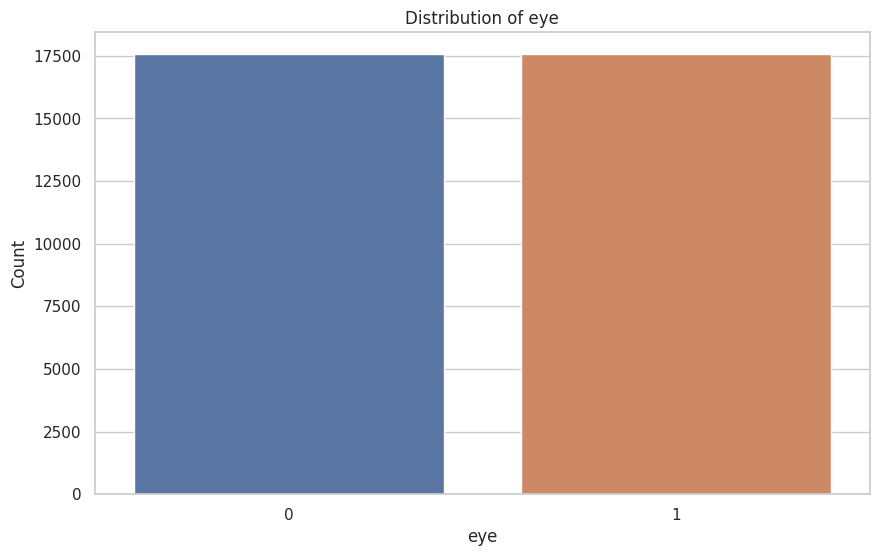

In [52]:
plt.figure(figsize=(10, 6))
sns.countplot(x='eye', data=df)
plt.title('Distribution of eye')
plt.xlabel('eye')
plt.ylabel('Count')
plt.show()

### Comparison of Left vs Right Eye

This comparison is done to see if there's any difference in the distribution of severity levels between left and right eyes.

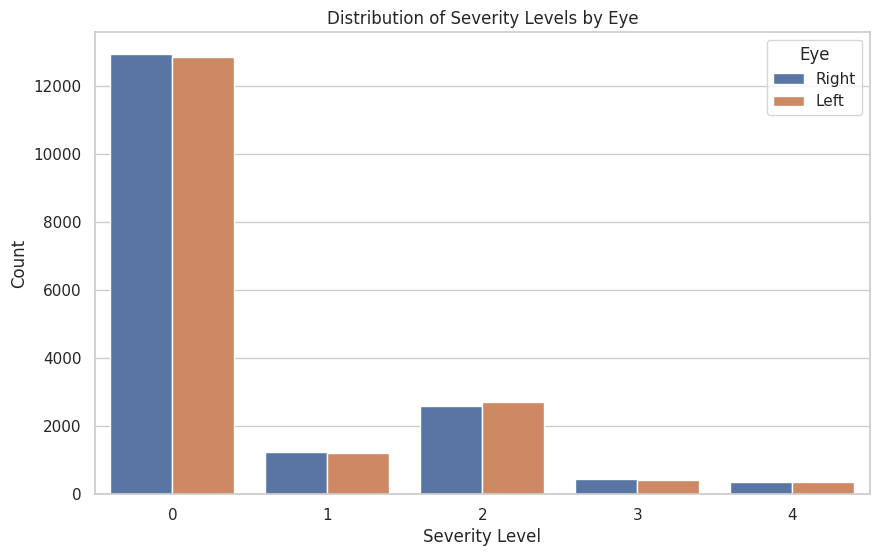

In [53]:
plt.figure(figsize=(10, 6))
sns.countplot(x='level', hue='eye', data=df)
plt.title('Distribution of Severity Levels by Eye')
plt.xlabel('Severity Level')
plt.ylabel('Count')
plt.legend(title='Eye', labels=['Right', 'Left'])
plt.show()

## Splitting data into Training and Testing

In [54]:
split = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, random_state = 0)

for train_index, test_index in split.split(df, df[['level']]):
    raw_train_df = df.loc[train_index]
    test_df = df.loc[test_index]

In [55]:
print('train:', raw_train_df.shape[0])
print('test:', test_df.shape[0])

train: 28100
test: 7026


## Oversampling

This is a function to oversample the dataset (so some of the images of levels 1-4 are present multiple times in the dataset):

In [56]:
def balance_data(df, class_size):
    balanced_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace=True)).reset_index(drop=True)
    balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', balanced_df.shape[0], 'Old Size:', df.shape[0])
    return balanced_df

New Data Size: 103240 Old Size: 28100


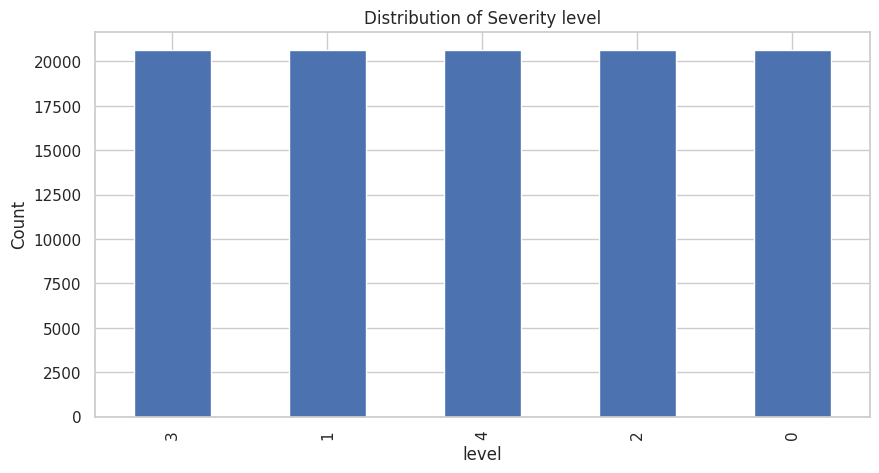

In [57]:
class_size = raw_train_df['level'].value_counts().max()
train_df_balanced = balance_data(raw_train_df, class_size)
train_df_balanced['level'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Distribution of Severity level')
plt.xlabel('level')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [58]:
im = Image.open(train_df_balanced['path'][1])
width, height = im.size
print(width,height)

256 256


## Data augmentation

In [59]:
def create_data_generators(train_df, test_df, x_col, y_col, target_size, batch_size):
    # Convert columns to string to ensure compatibility
    train_df[x_col] = train_df[x_col].astype(str)
    test_df[x_col] = test_df[x_col].astype(str)
    train_df[y_col] = train_df[y_col].astype(str)
    test_df[y_col] = test_df[y_col].astype(str)

    # Data augmentation parameters for the training data
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Normalization only for the test data
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Data generator for the training set
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col=x_col,
        y_col=y_col,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical', 
        shuffle=True
    )

    # Data generator for the test set
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col=x_col,
        y_col=y_col,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical', 
        shuffle=False
    )

    return train_generator, test_generator

In [60]:
batch_size = 128
target_size = (256, 256)
x_col = 'path'  
y_col = 'level'
train_generator, test_generator = create_data_generators(train_df_balanced, test_df, x_col, y_col, target_size, batch_size)

Found 103240 validated image filenames belonging to 5 classes.
Found 7026 validated image filenames belonging to 5 classes.


## Testing Data

In [ ]:
t_x, t_y = next(test_generator)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

## Training Data

In [ ]:
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

## Model

In [63]:
# Define input shape (example shape, adjust according to your data)
input_shape = (256, 256, 3)
num_classes = len(unique_level)

# Input layer
in_lay = Input(shape=input_shape)

# Pre-trained model
base_pretrained_model = PTModel(input_shape=input_shape, include_top=False, weights='imagenet')
base_pretrained_model.trainable = False

# Get features from pre-trained model
pt_features = base_pretrained_model(in_lay)

# Batch normalization
bn_features = BatchNormalization()(pt_features)

# Global Average Pooling
gap_features = GlobalAveragePooling2D()(bn_features)

# Dropout
gap_dr = Dropout(0.25)(gap_features)

# Fully connected layer
fc = Dense(128, activation='relu')(gap_dr)
fc_dr = Dropout(0.25)(fc)

# Output layer
out_layer = Dense(num_classes, activation='softmax')(fc_dr)

# Create model
retina_model = Model(inputs=[in_lay], outputs=[out_layer])

# Compile model
retina_model.compile(optimizer='adam', loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Model summary
retina_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 6, 6, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_284         │ (None, 6, 6, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,073,893 (84.21 MB)

 Trainable params: 267,013 (1.02 MB)

 Non-trainable params: 21,806,880 (83.19 MB)

In [64]:
es = EarlyStopping(monitor = 'val_loss', patience = 2, min_delta = 0.01)

In [65]:
model_history = retina_model.fit(train_generator, epochs = 10, verbose = 1, 
                                   validation_data = test_generator, callbacks = [es])

Epoch 1/10
807/807 ━━━━━━━━━━━━━━━━━━━━ 1630s 2s/step - accuracy: 0.3836 - loss: 1.4050 - val_accuracy: 0.3436 - val_loss: 1.2850
Epoch 2/10


W0000 00:00:1720001434.924065     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


807/807 ━━━━━━━━━━━━━━━━━━━━ 1582s 2s/step - accuracy: 0.4343 - loss: 1.2652 - val_accuracy: 0.3564 - val_loss: 1.2534
Epoch 3/10
807/807 ━━━━━━━━━━━━━━━━━━━━ 1576s 2s/step - accuracy: 0.4480 - loss: 1.2401 - val_accuracy: 0.3473 - val_loss: 1.2869
Epoch 4/10
807/807 ━━━━━━━━━━━━━━━━━━━━ 1572s 2s/step - accuracy: 0.4587 - loss: 1.2175 - val_accuracy: 0.3915 - val_loss: 1.2843


## Analyze Convergence

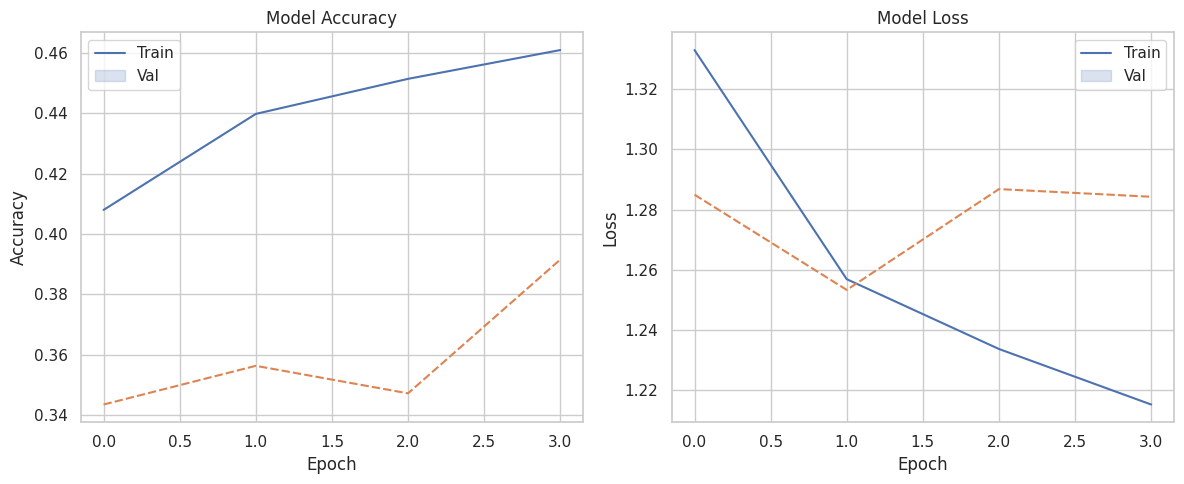

In [66]:
hist_df = pd.DataFrame(model_history.history)

sns.set(style='whitegrid')

# Plotting
plt.figure(figsize=(12, 5))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1) 
sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Subplot 2: Loss
plt.subplot(1, 2, 2)
sns.lineplot(data=hist_df[['loss', 'val_loss']])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')

plt.tight_layout() 
plt.show()

## Evaluate the Result

55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 454ms/step


W0000 00:00:1720006196.909159     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


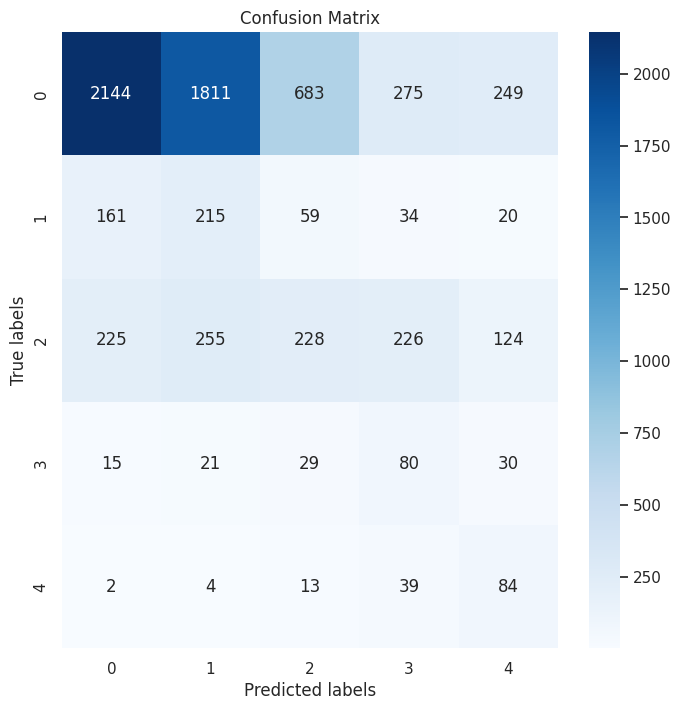

In [67]:
predictions = retina_model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys()) 

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [68]:
predictions_labels = np.argmax(predictions, axis=1)

In [69]:
test_df["level"] = test_df["level"].astype(int)
print(classification_report(test_df["level"], predictions_labels))

              precision    recall  f1-score   support

           0       0.84      0.42      0.56      5162
           1       0.09      0.44      0.15       489
           2       0.23      0.22      0.22      1058
           3       0.12      0.46      0.19       175
           4       0.17      0.59      0.26       142

    accuracy                           0.39      7026
   macro avg       0.29      0.42      0.28      7026
weighted avg       0.67      0.39      0.46      7026



In [70]:
# Saving the model
model_json = retina_model.to_json()
with open("drd.json", 'w') as json_file:
    json_file.write(model_json)
keras.saving.save_model(retina_model, 'drd.keras')